**Evaluation of Ichnos - Full Workshop Paper**

In [13]:
# Imports (for Graphs + Analysis)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from tabulate import tabulate
import sklearn
from sklearn.metrics import root_mean_squared_error

sns.set_theme(style='ticks', context='paper')

In [14]:
# Read Data from TS File
def read_ts(filename):
    ts_data = {}

    with open(filename, 'r') as f:
        data = f.readlines()

    for load, row_i in zip(range(0, 100, 10), range(1,12)):
        ts_data[load] = float(data[row_i].strip().split(',')[3])

    ts_data[100] = float(data[14].strip().split(',')[3])  # power consumption with maximize stress test

    mem_idle = float(data[1].strip().split(',')[4])
    mem_max = float(data[13].strip().split(',')[4])  # memory power consumption with VMStress stress test

    return (ts_data, (mem_idle, mem_max))

def get_average_ts_files(path):
    paths = [path.replace('ITER', str(iteration)) for iteration in range(1, 4)]
    readings = {}
    mem_readings = []

    for path in paths:
        (path_data, mem_data) = read_ts(path)

        for load,val in path_data.items():
            if load in readings:
                readings[load].append(val)
            else:
                readings[load] = [val]

        avg_mem_draw = (mem_data[0] + mem_data[1]) / 2
        mem_readings.append(avg_mem_draw)

    data = {}

    for load,vals in readings.items():
        data[load] = sum(vals) / 3

    overall_avg_mem_draw = sum(mem_readings) / 3

    return (data, overall_avg_mem_draw)

In [15]:
# Utilities
def get_linear_predictions(min, max):
    print(f'Idle: {min} | 100%: {max}')
    return [(min + (usage / 100) * (max - min)) for usage in range(0, 110, 10)]

MODELS = []

In [16]:
class Polynomial:
    def __init__(self, coefficients):
        self.coeffs = coefficients

    def __str__(self):
        chunks = []
        for coeff, power in zip(self.coeffs, range(len(self.coeffs), -1, -1)):
            if coeff == 0:
                continue
            chunks.append('(')
            chunks.append(self.format_coeff(coeff))
            chunks.append(self.format_power(power))
            chunks.append(') +')
        return ' '.join(chunks)

    @staticmethod
    def format_coeff(coeff):
        return str(coeff) if coeff < 0 else "{0}".format(coeff)

    @staticmethod
    def format_power(power):
        return ' * (x ** {0})'.format(power) if power != 0 else ''

In [17]:
# Helper Functions
def plot_ts_report(node, govs, total_mem):
    ts_paths = [f'data/{node}/ts/ts-{gov}-ITER.csv' for gov in govs]
    node_stats = {}

    for ts_path, gov in zip(ts_paths, govs):
        plt.figure(figsize=(6,3))

        (node_stats[f"{node}:{gov}"], mem_draw) = get_average_ts_files(ts_path)
        x = range(0,110,10)
        y = node_stats[f"{node}:{gov}"].values()
        y_arr = list(y)
        coefficients = np.polyfit(x, y_arr, 3)
        p = np.poly1d(coefficients)
        xp = np.linspace(0, 100)

        print(f'Node {node} w/ Governor {gov} -- Model Accuracy')
        print(f'Memory Power Draw: {mem_draw / total_mem}W/GB')

        linear_pred = get_linear_predictions(y_arr[0], y_arr[-1])
        linear_rmse = root_mean_squared_error(y_arr, linear_pred)
        print(f'RMSE of Linear Model: {linear_rmse}')
        model = Polynomial(p)
        MODELS.append(f'{node}:{gov}={model}')

        linear_v2_coef = np.polyfit(x, y_arr, 1)
        linear_v2 = np.poly1d(linear_v2_coef)
        linear_v2_x = np.linspace(0, 100)
        linear_v2_pred = [linear_v2(x_val) for x_val in x]
        linear_v2_rmse = root_mean_squared_error(y_arr, linear_v2_pred)
        model_linear_v2 = Polynomial(linear_v2)
        MODELS.append(f'{node}:{gov}-linear-v2={model_linear_v2}')
        print(f'RMSE of Linear v2 Model: {linear_v2_rmse}')

        y_pred = [p(x_val) for x_val in x]
        rmse = root_mean_squared_error(y_arr, y_pred)
        print(f'RMSE of Model: {rmse}')

        plt.scatter(x, y, label=f"{node}:{gov}", marker='x')
        plt.plot(xp, p(xp), label='cubic fit', color='green')
        plt.plot(linear_v2_x, linear_v2(linear_v2_x), label='linear-v2', color='blue')
        plt.plot(x, linear_pred, label='linear', color='red')
        
        plt.ylim(0,max(y)+10)
        plt.xticks(range(0,110,10))
        plt.xlabel('Load (%)')
        plt.ylabel('Energy Consumption (W)')
        plt.legend(loc='lower right')
        plt.title(f'Node {node} w/ Governor {gov}')

        plt.savefig(f'output/{node}-{gov}-models.pdf', bbox_inches='tight')
        plt.show()

In [18]:
# Constants
ENERGY_CONSUMPTION = "Energy Consumption (exc. PUE)"
ENERGY_CONSUMPTION_PUE = "Energy Consumption (inc. PUE)"
MEMORY_CONSUMPTION = "Memory Energy Consumption (exc. PUE)"
MEMORY_CONSUMPTION_PUE = "Memory Energy Consumption (inc. PUE)"
CARBON_EMISSIONS = "Carbon Emissions"

In [19]:
# Parse Key Details from Summary Files
def get_data(lines):
    data = {}

    for line in lines:
        parts = line.strip().split(':')
        parts[0] = parts[0][2:].strip()
        data[parts[0]] = parts[1].replace('kWh', '').replace('gCO2e', '').strip()

    return data


def get_bonus_data(lines):
    data = {}

    for line in lines:
        parts = line.strip().split(':')

        if line[0:4] == 'Task':
            data['runtime'] = float(line.replace('Task Runtime: ', '').replace('ms', '').strip())
        elif line[0:5] != '% CPU' and parts != ['']:
            data[parts[0]] = parts[1].replace('kWh', '').replace('gCO2e', '').strip()
        elif line[0:5] == '% CPU':
            cpu_mem_split = line.split('|')
            cpu = cpu_mem_split[0].strip()
            mem = cpu_mem_split[1].strip()

            data['cpu'] = cpu.replace('% CPU [', '').replace('%]', '')
            data['mem'] = mem.replace('% Memory [', '').replace('%]', '')

    return data


def parse_summary(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()

    info = get_data(lines[1:4])
    data = get_data(lines[7:12])
    bonus = get_bonus_data(lines[12:])

    return (info, data, bonus)


def get_average(first, second, third):
    data = {}

    for key in first.keys():
        data[key] = (float(first[key]) + float(second[key]) + float(third[key])) / 3

    return data


def print_summary(data):
    print(f"{ENERGY_CONSUMPTION}: {data[ENERGY_CONSUMPTION]}kWh")
    print(f"{ENERGY_CONSUMPTION_PUE}: {data[ENERGY_CONSUMPTION_PUE]}kWh")
    print(f"{MEMORY_CONSUMPTION}: {data[MEMORY_CONSUMPTION]}kWh")
    print(f"{MEMORY_CONSUMPTION_PUE}: {data[MEMORY_CONSUMPTION_PUE]}kWh")
    print(f"{CARBON_EMISSIONS}: {data[CARBON_EMISSIONS]}gCO2e")


def print_bonus(data):
    RES_MEM_ENERGY_CONSUMPTION = "Reserved Memory Energy Consumption"
    REST_MEM_CARBON_EMISSIONS = "Reserved Memory Carbon Emissions"

    print(f"{RES_MEM_ENERGY_CONSUMPTION}: {data[RES_MEM_ENERGY_CONSUMPTION]}kWh")
    print(f"{REST_MEM_CARBON_EMISSIONS}: {data[REST_MEM_CARBON_EMISSIONS]}kWh")
    print(f"CPU [{data['cpu']}% | {data['mem']}%] Memory")


def print_info(data_1, data_2, data_3):
    matches = data_1 == data_2 == data_3

    if not matches:
        print("[ERROR] Workflow Data does not match ...")
        return

    print(f"INFO: CPU Energy Consumption [{data_1['min to max watts']}] | PUE [{data_1['power-usage-effectiveness']}] | Memory Energy Consumption [{data_1['memory-power-draw']} W/GB]") 


def report_summary_for(filename_1, filename_2, filename_3, bonus=False):
    (info_1, data_1, bonus_1) = parse_summary(filename_1)
    (info_2, data_2, bonus_2) = parse_summary(filename_2)
    (info_3, data_3, bonus_3) = parse_summary(filename_3)
    avg_data = get_average(data_1, data_2, data_3)

    if bonus:
        avg_bonus = get_average(bonus_1, bonus_2, bonus_3)
        print_info(info_1, info_2, info_3)
        print_summary(avg_data)
        print_bonus(avg_bonus)
    else:
        print_summary(avg_data)

    return avg_data[CARBON_EMISSIONS]

In [20]:
# Mega Combined Function
def plot_ts_report_combined(nodes, govs, outname):
    overall_max = -1

    f, axs = plt.subplots(ncols=len(govs), nrows=len(nodes), sharey=True, sharex=True, figsize=(8.5,8))
    f.tight_layout(pad=0)
    for node, node_row in zip(nodes, range(0,len(nodes))):
        ts_paths = [f'data/{node}/ts/ts-{gov}-ITER.csv' for gov in govs]
        node_stats = {}

        for ax, ts_path, gov, gov_col in zip(axs, ts_paths, govs, range(0,len(govs))):
            ax = axs[node_row][gov_col]
            (node_stats[f"{node}:{gov}"], _) = get_average_ts_files(ts_path)
            x = range(0,110,10)
            y = node_stats[f"{node}:{gov}"].values()
            y_arr = list(y)

            coefficients = np.polyfit(x, y_arr, 3)
            p = np.poly1d(coefficients)
            xp = np.linspace(0, 100)

            linear_pred = get_linear_predictions(y_arr[0], y_arr[-1])
            linear_v2_coef = np.polyfit(x, y_arr, 1)
            linear_v2 = np.poly1d(linear_v2_coef)
            linear_v2_x = np.linspace(0, 100)

            ax.scatter(x, y, marker='x', label='Readings', color='#e66101')
            ax.plot(xp, p(xp), label='Ichnos-Cubic', color='#fdb863')
            ax.plot(linear_v2_x, linear_v2(linear_v2_x), label='Ichnos-Linear', color='#b2abd2')
            ax.plot(x, linear_pred, label='Linear', color='#5e3c99')

            if gov_col == 0:
                ax.set_ylabel(node)

            if max(y) + 10 > overall_max:
                overall_max = max(y) + 10

    f.text(0.2, 1, 'ondemand', ha='center')
    f.text(0.52, 1, 'performance', ha='center')
    f.text(0.85, 1, 'powersave', ha='center')
    f.text(0.52, -0.02, 'Load (%)', ha='center')

    ax.set_ylim(0,overall_max)
    ax.set_xticks(range(0,110,10))
    handles, _ = ax.get_legend_handles_labels()
    f.legend(handles, ['Readings', 'Ichnos-Cubic', 'Ichnos-Linear', 'Linear'], loc='upper right', bbox_to_anchor=(1.16, 1.02), frameon=False)
    f.text(-0.05, 0.5, 'Energy Consumption (W)', ha='center', va='center', rotation='vertical')

    plt.savefig(f'output/{outname}.pdf', bbox_inches='tight')
    plt.show()

**Observations**
- performance follows a similar pattern to ondemand on all the old GPG nodes, where there is a gap between that and power consumed using powersave
- node 15 (old GPG node) has a higher peak power consumption compared to the others, maybe less utilised, shows that not all devices will age the same
- more recent node, node 22 has close readings when comparing performance to powersave
- the RMSE of the cubic fit improves on the linear, which is what Ichnos would default to, and what Green Algorithms and similar approaches use
- theoretically, taking these measurements and then running the script should allow for the use of a cubic model when estimating the footprint

In [21]:
# Calculate the Energy from each Workflow Execution
def parse_perf_log(filename, new_node=False):
    with open(filename) as f:
        lines = f.readlines()
        data = []

        for line in lines:
            if line.strip():
                data.append(line.strip())

    vals = {}
    vals['start'] = ' '.join(data[0].split(' ')[3:])

    if new_node:
        vals['pkg'] = float(data[2].split(' ')[0].replace(',', ''))
        vals['ram'] = float(data[3].split(' ')[0].replace(',', ''))
        vals['time'] = float(data[4].split(' ')[0].replace(',', ''))
    else:
        vals['pkg'] = float(data[3].split(' ')[0].replace(',', ''))
        vals['ram'] = float(data[4].split(' ')[0].replace(',', ''))
        vals['time'] = float(data[5].split(' ')[0].replace(',', ''))

    return vals

def joules_to_kwh(joules):
    return joules / 3600000

In [22]:
# Helpful Functions for Stats Reporting
def generate_stats_for_node_by_model(node, workflow, ci, model, gov):
    (info_1, data_1, bonus_1) = parse_summary(f'data/{node}/{gov}/results/{workflow}-1-{ci}-{model}-summary.txt')
    (info_2, data_2, bonus_2) = parse_summary(f'data/{node}/{gov}/results/{workflow}-2-{ci}-{model}-summary.txt')
    (info_3, data_3, bonus_3) = parse_summary(f'data/{node}/{gov}/results/{workflow}-3-{ci}-{model}-summary.txt')

    model_avg = get_average(data_1, data_2, data_3)
    energy_avg = model_avg[ENERGY_CONSUMPTION] + model_avg[MEMORY_CONSUMPTION]
    emissions_avg = model_avg[CARBON_EMISSIONS]
    # runtime_avg = round((sum([bonus_1['runtime'], bonus_2['runtime'], bonus_3['runtime']]) / 3) / 1000 / 3600, 2)

    if model in ['baseline', 'linear']:
        record_name = gov + "_" + model
    else:
        record_name = model

    return [record_name, model_avg[ENERGY_CONSUMPTION], model_avg[MEMORY_CONSUMPTION], model_avg[ENERGY_CONSUMPTION] + model_avg[MEMORY_CONSUMPTION], emissions_avg]


def generate_node_stats_all_models(node, workflow, ci, model_prefix, govs, new_node=False):
    records = []

    # perf 
    for gov in govs:
        perf_data_1 = parse_perf_log(f'data/{node}/{gov}/perf-1.txt', new_node)
        perf_data_2 = parse_perf_log(f'data/{node}/{gov}/perf-2.txt', new_node)
        perf_data_3 = parse_perf_log(f'data/{node}/{gov}/perf-3.txt', new_node)
        perf_avg_pkg = joules_to_kwh(sum([perf_data_1['pkg'], perf_data_2['pkg'], perf_data_3['pkg']]) / 3)
        perf_avg_ram = joules_to_kwh(sum([perf_data_1['ram'], perf_data_2['ram'], perf_data_3['ram']]) / 3)
        records.append([f'perf_{gov}', perf_avg_pkg, perf_avg_ram, perf_avg_pkg + perf_avg_ram, None])

    # ichnos per model
    for gov in govs:
        model = f"{model_prefix}_{gov}"
        records.append(generate_stats_for_node_by_model(node, workflow, ci, model, gov))
        records.append(generate_stats_for_node_by_model(node, workflow, ci, model + '_linear', gov))
        records.append(generate_stats_for_node_by_model(node, workflow, ci, 'linear', gov))
        records.append(generate_stats_for_node_by_model(node, workflow, ci, 'baseline', gov))

    return records

headers = ['setting', 'core_energy (kWh)', 'ram energy (kWh)', 'total energy (kWh)', 'emissions (gCO2e)']

In [23]:
# Report Error for Records
def report_error(node, gov, data):
    perf_reading = None
    other_readings = []
    error_rows = []

    if gov == 'performance|powersave':
        performance_error_rows = report_error(node, 'performance', [data[0], data[2], data[3], data[4], data[5]])
        powersave_error_rows = report_error(node, 'powersave', [data[1], data[6], data[7], data[8], data[9]])
        error_rows = performance_error_rows + powersave_error_rows
    else:
        for row in data:
            if row[0] == f'perf_{gov}':
                perf_reading = row
            else:
                other_readings.append(row)

        perf_pkg = perf_reading[1]
        perf_ram = perf_reading[2]
        perf_total = perf_reading[3]

        for reading in other_readings:
            pkg_err = (abs(perf_pkg - reading[1]) / perf_pkg) * 100
            ram_err = (abs(perf_ram - reading[2]) / perf_ram) * 100
            total_err = (abs(perf_total - reading[3]) / perf_total) * 100
            error_rows.append([reading[0], reading[1], pkg_err, reading[2], ram_err, reading[3], total_err, reading[4]])

    return error_rows

err_headers = ['setting', 'core (kWh)', 'core error (%)', 'ram (kWh)', 'ram error (%)', 'total (kWh)', 'total_err (%)', 'emissions (gCO2e)']


In [24]:
# Plot Graph Containing all on One Row, with a max. of 3 sub-plots
def plot_ts_single_row(nodes, govs_by_node, outname):
    overall_max = -1
    max_govs = 0

    for node_govs in govs_by_node:
        if len(node_govs) > max_govs:
            max_govs = len(node_govs)

    f,axs = plt.subplots(ncols=max_govs, nrows=1, sharey=True, sharex=True, figsize=(10,3))
    f.tight_layout(pad=0)

    colours = ['#d73027', '#4575b4']
    ichnos_cubics = []
    ichnos_linears = []
    naive_linears = []
    plots = []

    for node, govs, col_ind, symbol in zip(nodes, govs_by_node, [0,1], ['', '*']):
        ts_paths = [f'data/{node}/ts/ts-{gov}-ITER.csv' for gov in govs]
        node_stats = {}
        p1 = plt.plot([], marker='', ls='')

        for ts_path, gov, ax in zip(ts_paths, govs, axs):
            (node_stats[f"{node}:{gov}"], _) = get_average_ts_files(ts_path)
            x = range(0, 110, 10)
            y = node_stats[f"{node}:{gov}"].values()
            y_arr = list(y)

            # Ichnos-Cubic
            coefficients = np.polyfit(x, y_arr, 3)
            p = np.poly1d(coefficients)
            xp = np.linspace(0, 100)
            ichnos_cubics.append(ax.plot(xp, p(xp), label=f'Ichnos-Cubic{symbol}', color=colours[col_ind], linestyle='solid'))

            # Naive-Linear
            linear_pred = get_linear_predictions(y_arr[0], y_arr[-1])
            naive_linears.append(ax.plot(x, linear_pred, label=f'Naive-Linear{symbol}', color=colours[col_ind], linestyle='dashed'))

            # Ichnos-Linear
            linear_v2_coef = np.polyfit(x, y_arr, 1)
            linear_v2 = np.poly1d(linear_v2_coef)
            linear_v2_x = np.linspace(0, 100)
            ichnos_linears.append(ax.plot(linear_v2_x, linear_v2(linear_v2_x), label=f'Ichnos-Linear{symbol}', color=colours[col_ind], linestyle='dotted'))

            # RAPL (perf) Readings
            plots.append(ax.scatter(x, y, marker='x', label=f'Turbostress{symbol}', color=colours[col_ind]))

            if max(y) + 25 > overall_max:
                overall_max = max(y) + 25

        p2 = plt.plot([], marker='', ls='')
        f.text(0.2, 1.01, 'ondemand', ha='center')
        f.text(0.52, 1.01, 'performance', ha='center')
        f.text(0.85, 1.01, 'powersave', ha='center')
        f.text(0.52, -0.04, 'Load (%)', ha='center')

    p3 = plt.plot([], marker='', ls='')

    ax.set_ylim(25,overall_max)
    ax.set_xticks(range(0,110,10))
    handles,labels = ax.get_legend_handles_labels()
    handles = p1 + handles[:4] + p2 + p3 + handles[4:]
    labels = ['gpgnode-15'] + labels[:4] + [''] + ['gpgnode-16'] + labels[4:]
    f.legend(handles, labels, bbox_to_anchor=(1.15, 0.96), frameon=False, prop={'size': 10})
    f.text(-0.02, 0.5, 'Energy Consumption (W)', ha='center', va='center', rotation='vertical')

    plt.rcParams.update({'font.size': 12})
    plt.savefig(f'output/{outname}.pdf', bbox_inches='tight')
    plt.show()

Idle: 54.88666666666666 | 100%: 138.81666666666666
Idle: 52.949999999999996 | 100%: 120.30333333333334
Idle: 53.53333333333333 | 100%: 139.12
Idle: 46.53 | 100%: 111.57
Idle: 45.699999999999996 | 100%: 96.99333333333334
Idle: 46.21666666666667 | 100%: 111.82333333333334
Idle: 117.37 | 100%: 345.76666666666665
Idle: 94.77333333333333 | 100%: 347.1433333333334


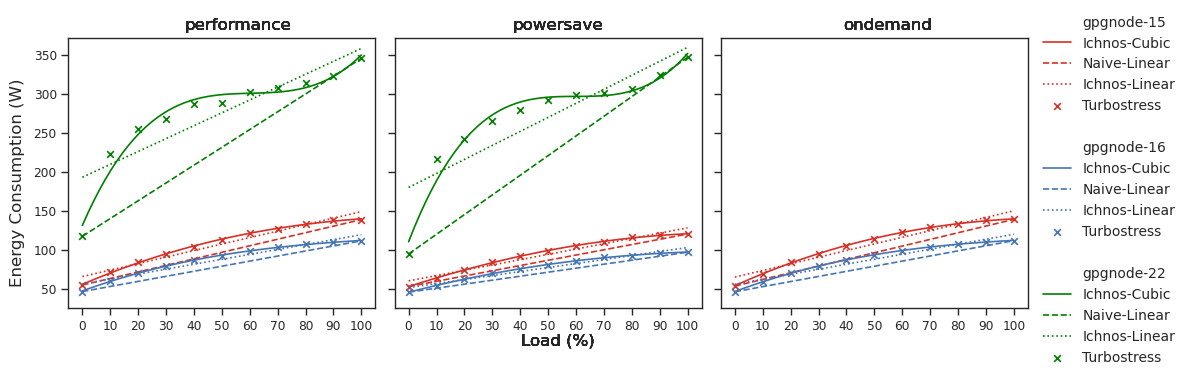

In [ ]:
# Plot Node 15, 16 and 22
overall_max = -1

f,axs = plt.subplots(ncols=3, nrows=1, sharey=True, sharex=True, figsize=(10,3))
f.tight_layout(pad=0)

colours = ['#d73027', '#4575b4', 'green']
plots = []
nodes = ['gpgnode-15', 'gpgnode-16', 'gpgnode-22']
all_3 = ['performance', 'powersave', 'ondemand']
just_2 = ['performance', 'powersave']
symbols = ['', '*', '']

for node, symbol, colour_ind in zip(nodes, symbols, range(0, 3)):
    if node == 'gpgnode-22':
        govs = just_2
    else:
        govs = all_3

    ts_paths = [f'data/{node}/ts/ts-{governor}-ITER.csv' for governor in govs]
    node_stats = {}
    p1 = plt.plot([], marker='', ls='')

    for ts_path, gov, col in zip(ts_paths, govs, range(0, len(govs))):
        (node_stats[f"{node}:{gov}"], _) = get_average_ts_files(ts_path)
        x = range(0, 110, 10)
        y = node_stats[f"{node}:{gov}"].values()
        y_arr = list(y)

        # Ichnos-Cubic
        coefficients = np.polyfit(x, y_arr, 3)
        p = np.poly1d(coefficients)
        xp = np.linspace(0, 100)
        axs[col].plot(xp, p(xp), label=f'Ichnos-Cubic', color=colours[colour_ind], linestyle='solid')

        # Naive-Linear
        linear_pred = get_linear_predictions(y_arr[0], y_arr[-1])
        axs[col].plot(x, linear_pred, label=f'Naive-Linear', color=colours[colour_ind], linestyle='dashed')

        # Ichnos-Linear
        linear_v2_coef = np.polyfit(x, y_arr, 1)
        linear_v2 = np.poly1d(linear_v2_coef)
        linear_v2_x = np.linspace(0, 100)
        axs[col].plot(linear_v2_x, linear_v2(linear_v2_x), label=f'Ichnos-Linear', color=colours[colour_ind], linestyle='dotted')

        # RAPL (perf) Readings
        axs[col].scatter(x, y, marker='x', label=f'Turbostress', color=colours[colour_ind])

        if max(y) + 25 > overall_max:
            overall_max = max(y) + 25

        p2 = plt.plot([], marker='', ls='')

        f.text(0.2, 1.01, 'performance', ha='center')
        f.text(0.52, 1.01, 'powersave', ha='center')
        f.text(0.85, 1.01, 'ondemand', ha='center')
        f.text(0.52, -0.04, 'Load (%)', ha='center')

        p3 = plt.plot([], marker='', ls='')

axs[0].set_ylim(25,overall_max)
axs[0].set_xticks(range(0,110,10))
handles,labels = axs[0].get_legend_handles_labels()
handles = p1 + handles[:4] + p2 + p3 + handles[4:8] + p2 + p3 + handles[8:]
labels = ['gpgnode-15'] + labels[:4] + [''] + ['gpgnode-16'] + labels[4:8] + [''] + ['gpgnode-22'] + labels[8:]
f.legend(handles, labels, bbox_to_anchor=(1.15, 1.10), frameon=False, prop={'size': 10})
f.text(-0.02, 0.5, 'Energy Consumption (W)', ha='center', va='center', rotation='vertical')

plt.rcParams.update({'font.size': 12})
plt.savefig(f'output/combined-nodes-15-16-22.pdf', bbox_inches='tight')
plt.show()

Idle: 53.53333333333333 | 100%: 139.12
Idle: 54.88666666666666 | 100%: 138.81666666666666
Idle: 52.949999999999996 | 100%: 120.30333333333334
Idle: 46.21666666666667 | 100%: 111.82333333333334
Idle: 46.53 | 100%: 111.57
Idle: 45.699999999999996 | 100%: 96.99333333333334


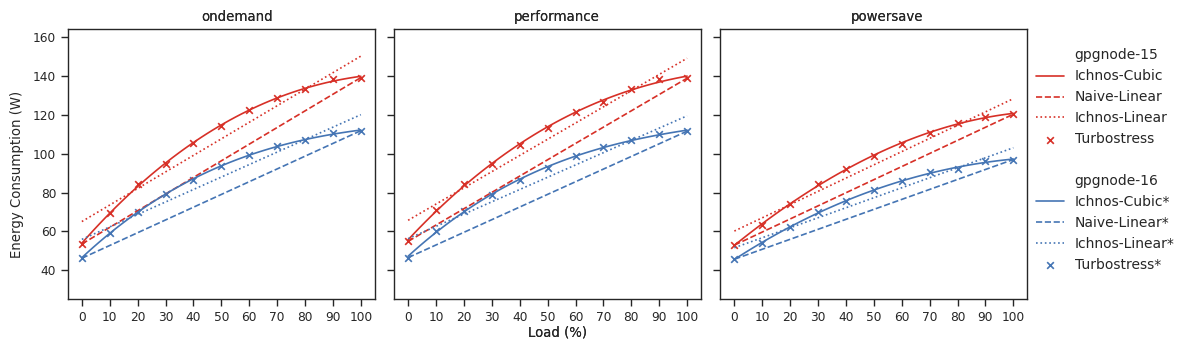

In [ ]:
# Work in Progress
all_3 = ['ondemand', 'performance', 'powersave']
plot_ts_single_row(['gpgnode-15', 'gpgnode-16'], [all_3, all_3], 'gpgnodes-15-16-models')


Idle: 48.26 | 100%: 124.96333333333332
Idle: 49.056666666666665 | 100%: 124.95333333333333
Idle: 48.166666666666664 | 100%: 104.88666666666666
Idle: 49.833333333333336 | 100%: 125.08
Idle: 50.56666666666666 | 100%: 125.25
Idle: 49.413333333333334 | 100%: 105.60666666666667
Idle: 53.53333333333333 | 100%: 139.12
Idle: 54.88666666666666 | 100%: 138.81666666666666
Idle: 52.949999999999996 | 100%: 120.30333333333334
Idle: 46.21666666666667 | 100%: 111.82333333333334
Idle: 46.53 | 100%: 111.57
Idle: 45.699999999999996 | 100%: 96.99333333333334


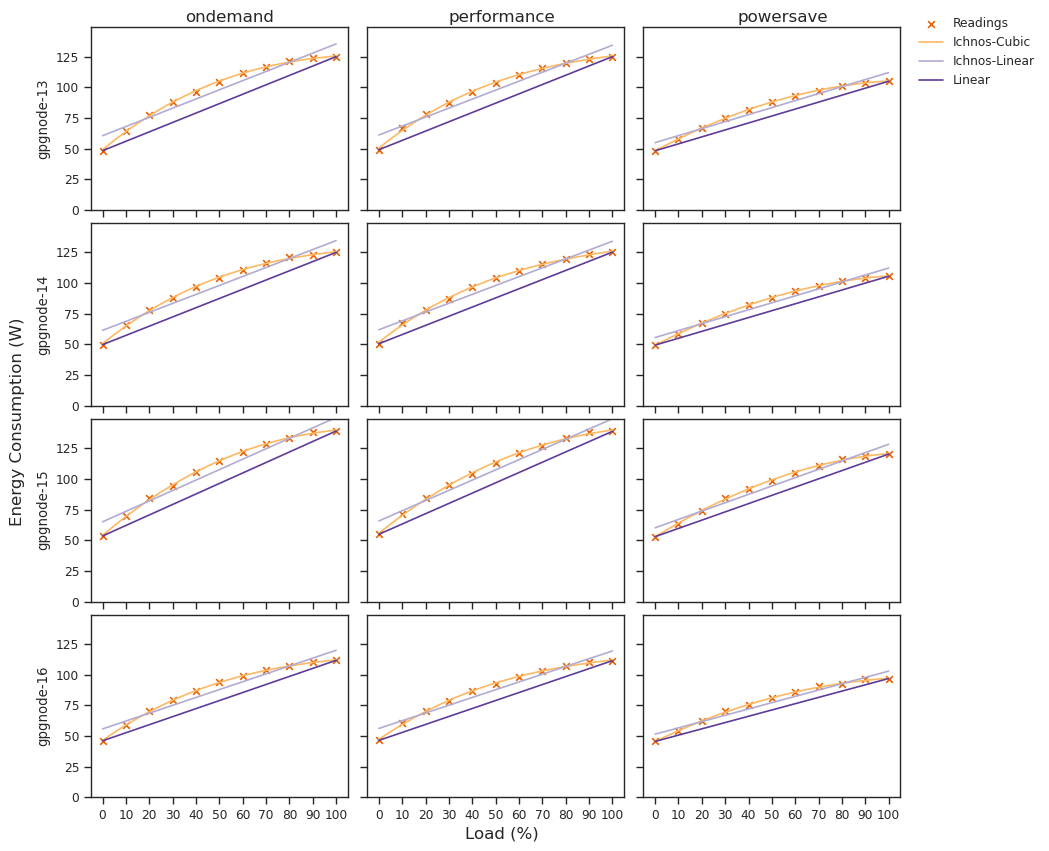

In [26]:
# Combined Plot for Discussion
plot_ts_report_combined(['gpgnode-13', 'gpgnode-14', 'gpgnode-15', 'gpgnode-16'], ['ondemand', 'performance', 'powersave'], 'combined-gpgnodes-old')

In [42]:
# Plot for GPG Node 22
def plot_node_22(node, govs, outname): 
    overall_max = -1

    f, axs = plt.subplots(ncols=len(govs), nrows=1, sharey=True, sharex=True, figsize=(6.5,2))
    f.tight_layout(pad=0)
    ts_paths = [f'data/{node}/ts/ts-{gov}-ITER.csv' for gov in govs]
    node_stats = {}
    p1 = plt.plot([], marker='', ls='')

    for ax, ts_path, gov in zip(axs, ts_paths, govs):
        (node_stats[f"{node}:{gov}"], _) = get_average_ts_files(ts_path)
        x = range(0,110,10)
        y = node_stats[f"{node}:{gov}"].values()
        y_arr = list(y)

        coefficients = np.polyfit(x, y_arr, 3)
        p = np.poly1d(coefficients)
        xp = np.linspace(0, 100)

        linear_pred = get_linear_predictions(y_arr[0], y_arr[-1])
        linear_v2_coef = np.polyfit(x, y_arr, 1)
        linear_v2 = np.poly1d(linear_v2_coef)
        linear_v2_x = np.linspace(0, 100)

        ax.scatter(x, y, marker='x', label='Perf', color='#1b7837')
        ax.plot(xp, p(xp), label='Ichnos-Cubic', color='#1b7837', linestyle='solid')
        ax.plot(linear_v2_x, linear_v2(linear_v2_x), label='Ichnos-Linear', color='#1b7837', linestyle='dotted')
        ax.plot(x, linear_pred, label='Naive-Linear', color='#1b7837', linestyle='dashed')

        if max(y) + 25 > overall_max:
            overall_max = max(y) + 25

        f.text(0.28, 1, 'performance', ha='center')
        f.text(0.75, 1, 'powersave', ha='center')
        f.text(0.52, -0.07, 'Load (%)', ha='center')

    ax.set_ylim(25,overall_max)
    ax.set_xticks(range(0,110,10))
    handles, _ = ax.get_legend_handles_labels()
    handles = p1 + handles
    f.legend(handles, ['gpgnode-22', 'Turbostress', 'Ichnos-Cubic', 'Ichnos-Linear', 'Naive-Linear'], loc='upper right', bbox_to_anchor=(1.22, 1.02), frameon=False, prop={'size': 10})
    f.text(-0.02, 0.5, 'Energy Consumption (W)', ha='center', va='center', rotation='vertical')
    plt.rcParams.update({'font.size': 12})
    plt.savefig(f'output/{outname}.pdf', bbox_inches='tight')
    plt.show()

Idle: 117.37 | 100%: 345.76666666666665
Idle: 94.77333333333333 | 100%: 347.1433333333334


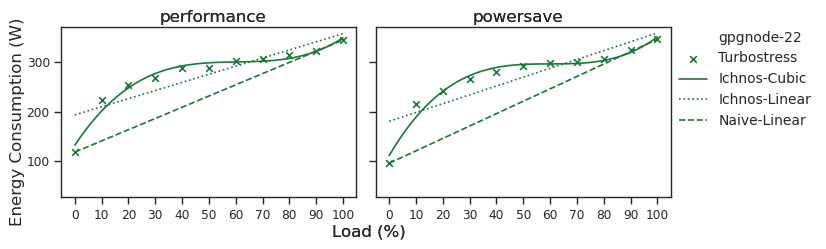

In [28]:
# Combined Plot for Discussion
plot_node_22('gpgnode-22', ['performance', 'powersave'], 'gpgnode-22')

Node gpgnode-13 w/ Governor ondemand -- Model Accuracy
Memory Power Draw: 0.40268229166666664W/GB
Idle: 48.26 | 100%: 124.96333333333332
RMSE of Linear Model: 12.963803425014767
RMSE of Linear v2 Model: 6.348509315784198
RMSE of Model: 0.5905366018614144


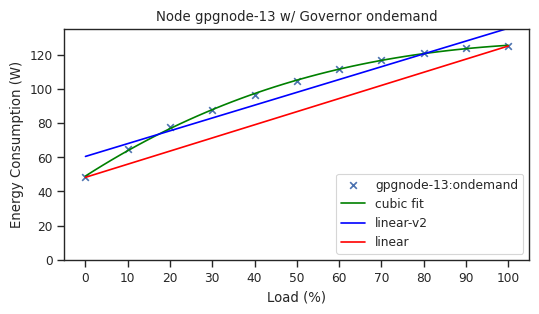

Node gpgnode-13 w/ Governor performance -- Model Accuracy
Memory Power Draw: 0.407421875W/GB
Idle: 49.056666666666665 | 100%: 124.95333333333333
RMSE of Linear Model: 12.141152394424777
RMSE of Linear v2 Model: 5.8257216446856654
RMSE of Model: 0.8371410443916413


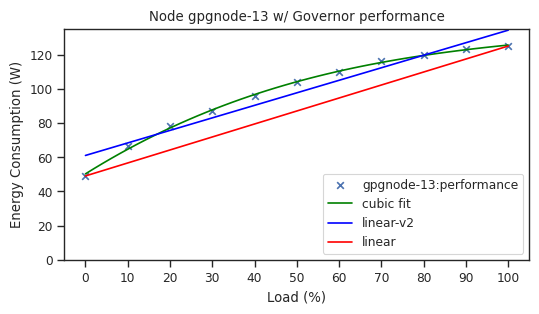

Node gpgnode-13 w/ Governor powersave -- Model Accuracy
Memory Power Draw: 0.40752604166666667W/GB
Idle: 48.166666666666664 | 100%: 104.88666666666666
RMSE of Linear Model: 7.946516039857798
RMSE of Linear v2 Model: 4.016264037980226
RMSE of Model: 0.22019884802003745


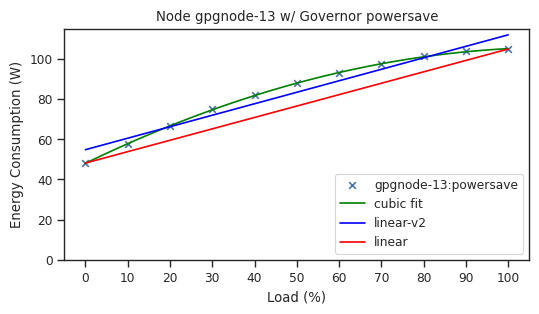

In [29]:
# Graph the Power Consumption for gpgnode-13
governors = ['ondemand', 'performance', 'powersave']
plot_ts_report('gpgnode-13', governors, 64)

In [30]:
# GPG Node 13
print('GPG Node 13')
gpgnode_13 = generate_node_stats_all_models('gpgnode-13', 'ampliseq', 'south-scotland-300125-110225', 'gpg_13', ['ondemand'])
print(tabulate(gpgnode_13, headers, tablefmt='orgtbl'))
print('')
error_rows = report_error('gpg_13', 'ondemand', gpgnode_13)
print(tabulate(error_rows, err_headers, tablefmt='orgtbl'))

GPG Node 13
| setting                |   core_energy (kWh) |   ram energy (kWh) |   total energy (kWh) |   emissions (gCO2e) |
|------------------------+---------------------+--------------------+----------------------+---------------------|
| perf_ondemand          |           0.12902   |          0.0318215 |             0.160841 |                     |
| gpg_13_ondemand        |           0.122986  |          0.0119519 |             0.134938 |            2.74367  |
| gpg_13_ondemand_linear |           0.132374  |          0.0119519 |             0.144325 |            2.93489  |
| ondemand_linear        |           0.108796  |          0.0122776 |             0.121074 |            2.46189  |
| ondemand_baseline      |           0.0152994 |          0.0122776 |             0.027577 |            0.557551 |

| setting                |   core (kWh) |   core error (%) |   ram (kWh) |   ram error (%) |   total (kWh) |   total_err (%) |   emissions (gCO2e) |
|------------------------+-------

Node gpgnode-14 w/ Governor ondemand -- Model Accuracy
Memory Power Draw: 0.35932291666666666W/GB
Idle: 49.833333333333336 | 100%: 125.08
RMSE of Linear Model: 12.20992542106128
RMSE of Linear v2 Model: 5.972893953211332
RMSE of Model: 0.6120792988027645


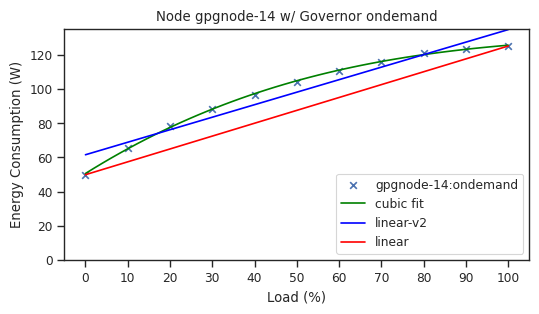

Node gpgnode-14 w/ Governor performance -- Model Accuracy
Memory Power Draw: 0.36736979166666667W/GB
Idle: 50.56666666666666 | 100%: 125.25
RMSE of Linear Model: 11.552112590475836
RMSE of Linear v2 Model: 5.49177640484462
RMSE of Model: 0.8599092931066993


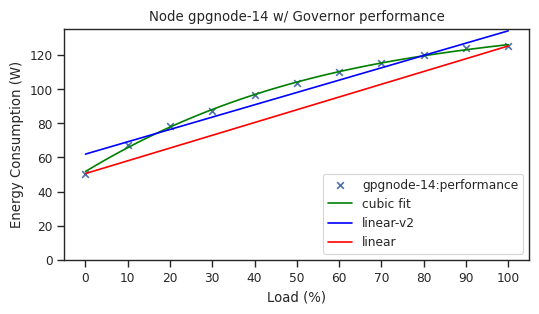

Node gpgnode-14 w/ Governor powersave -- Model Accuracy
Memory Power Draw: 0.35888020833333334W/GB
Idle: 49.413333333333334 | 100%: 105.60666666666667
RMSE of Linear Model: 7.454049838168443
RMSE of Linear v2 Model: 3.7716310625987757
RMSE of Model: 0.2915081891173531


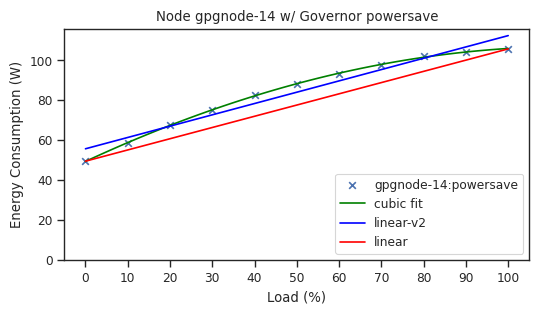

In [31]:
# Graph the Power Consumption for gpgnode-14
governors = ['ondemand', 'performance', 'powersave']
plot_ts_report('gpgnode-14', governors, 64)

In [32]:
# GPG Node 14
print('GPG Node 14')
gpgnode_14 = generate_node_stats_all_models('gpgnode-14', 'ampliseq', 'south-scotland-300125-110225', 'gpg_14', ['performance', 'powersave'])
print(tabulate(gpgnode_14, headers, tablefmt='orgtbl'))
print('')
error_rows = report_error('gpg_14', 'performance|powersave', gpgnode_14)
print(tabulate(error_rows, err_headers, tablefmt='orgtbl'))

GPG Node 14
| setting                   |   core_energy (kWh) |   ram energy (kWh) |   total energy (kWh) |   emissions (gCO2e) |
|---------------------------+---------------------+--------------------+----------------------+---------------------|
| perf_performance          |           0.133685  |          0.0269157 |            0.1606    |                     |
| perf_powersave            |           0.129391  |          0.0294548 |            0.158846  |                     |
| gpg_14_performance        |           0.126612  |          0.0112013 |            0.137813  |            2.7919   |
| gpg_14_performance_linear |           0.13475   |          0.0112013 |            0.145951  |            2.9571   |
| performance_linear        |           0.112858  |          0.0112013 |            0.124059  |            2.51339  |
| performance_baseline      |           0.0149936 |          0.0112013 |            0.0261949 |            0.528041 |
| gpg_14_powersave          |           0.13

Node gpgnode-15 w/ Governor ondemand -- Model Accuracy
Memory Power Draw: 0.40739583333333335W/GB
Idle: 53.53333333333333 | 100%: 139.12
RMSE of Linear Model: 12.963841127060945
RMSE of Linear v2 Model: 6.359924556730956
RMSE of Model: 0.6185222221970276


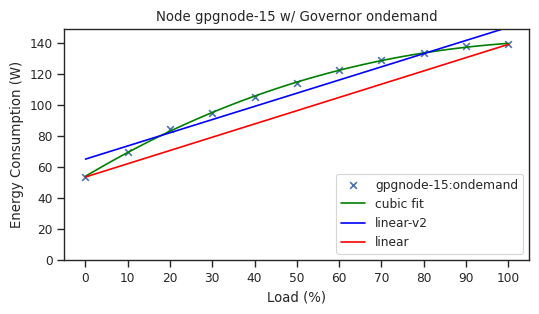

Node gpgnode-15 w/ Governor performance -- Model Accuracy
Memory Power Draw: 0.4091666666666667W/GB
Idle: 54.88666666666666 | 100%: 138.81666666666666
RMSE of Linear Model: 12.009487009540555
RMSE of Linear v2 Model: 5.724325160221502
RMSE of Model: 0.853678681133499


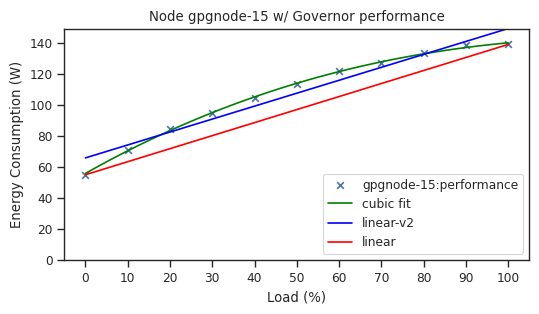

Node gpgnode-15 w/ Governor powersave -- Model Accuracy
Memory Power Draw: 0.40458333333333335W/GB
Idle: 52.949999999999996 | 100%: 120.30333333333334
RMSE of Linear Model: 8.815726225835785
RMSE of Linear v2 Model: 4.426237527532582
RMSE of Model: 0.47731927844907446


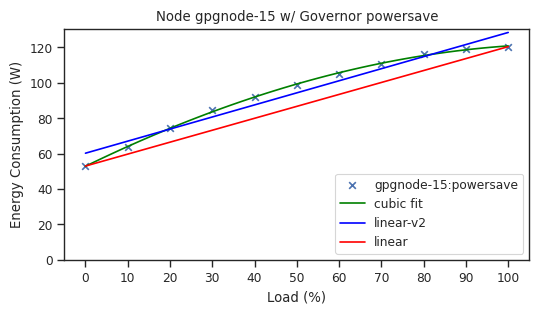

In [33]:
# Graph the Power Consumption for gpgnode-15
governors = ['ondemand', 'performance', 'powersave']
plot_ts_report('gpgnode-15', governors, 64)

In [34]:
# GPG Node 15
print('GPG Node 15')
gpgnode_15 = generate_node_stats_all_models('gpgnode-15', 'ampliseq', 'south-scotland-300125-110225', 'gpg_15', ['performance', 'powersave'])
print(tabulate(gpgnode_15, headers, tablefmt='orgtbl'))
print('')
error_rows = report_error('gpg_15', 'performance|powersave', gpgnode_15)
print(tabulate(error_rows, err_headers, tablefmt='orgtbl'))

GPG Node 15
| setting                   |   core_energy (kWh) |   ram energy (kWh) |   total energy (kWh) |   emissions (gCO2e) |
|---------------------------+---------------------+--------------------+----------------------+---------------------|
| perf_performance          |           0.136789  |          0.0309487 |            0.167737  |                     |
| perf_powersave            |           0.141688  |          0.035876  |            0.177564  |                     |
| gpg_15_performance        |           0.134582  |          0.0123807 |            0.146962  |            1.688    |
| gpg_15_performance_linear |           0.143008  |          0.0123807 |            0.155389  |            1.78571  |
| performance_linear        |           0.122043  |          0.0123807 |            0.134424  |            1.54456  |
| performance_baseline      |           0.0151042 |          0.0123807 |            0.027485  |            0.313393 |
| gpg_15_powersave          |           0.14

Node gpgnode-16 w/ Governor ondemand -- Model Accuracy
Memory Power Draw: 0.34205729166666665W/GB
Idle: 46.21666666666667 | 100%: 111.82333333333334
RMSE of Linear Model: 10.33129852888441
RMSE of Linear v2 Model: 5.126372045505865
RMSE of Model: 0.3381183780550558


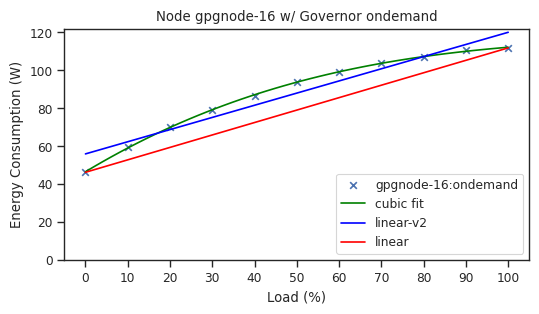

Node gpgnode-16 w/ Governor performance -- Model Accuracy
Memory Power Draw: 0.34734375W/GB
Idle: 46.53 | 100%: 111.57
RMSE of Linear Model: 10.097307291820655
RMSE of Linear v2 Model: 4.882609321181393
RMSE of Model: 0.5307623440987613


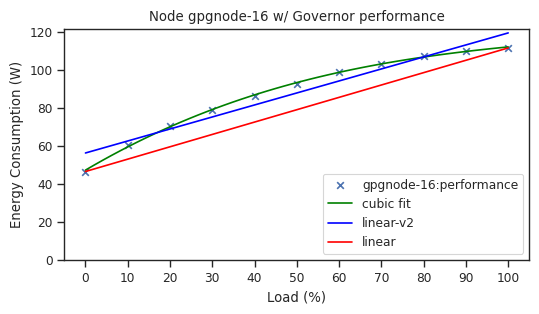

Node gpgnode-16 w/ Governor powersave -- Model Accuracy
Memory Power Draw: 0.337578125W/GB
Idle: 45.699999999999996 | 100%: 96.99333333333334
RMSE of Linear Model: 6.936732077800895
RMSE of Linear v2 Model: 3.5187526681711
RMSE of Model: 0.47221389328215035


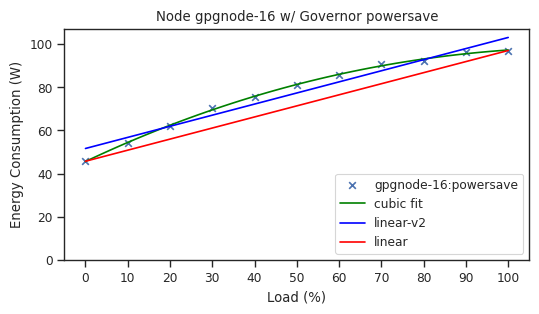

In [35]:
# Graph the Power Consumption for gpgnode-16
governors = ['ondemand', 'performance', 'powersave']
plot_ts_report('gpgnode-16', governors, 64)

In [36]:
# GPG Node 16
print('GPG Node 16')
gpgnode_16 = generate_node_stats_all_models('gpgnode-16', 'ampliseq', 'south-scotland-300125-110225', 'gpg_16', ['ondemand'])
print(tabulate(gpgnode_16, headers, tablefmt='orgtbl'))
print('')
error_rows = report_error('gpg_16', 'ondemand', gpgnode_16)
print(tabulate(error_rows, err_headers, tablefmt='orgtbl'))

GPG Node 16
| setting                |   core_energy (kWh) |   ram energy (kWh) |   total energy (kWh) |   emissions (gCO2e) |
|------------------------+---------------------+--------------------+----------------------+---------------------|
| perf_ondemand          |           0.115035  |          0.0236347 |             0.138669 |                     |
| gpg_16_ondemand        |           0.113387  |          0.0103723 |             0.123759 |             7.44512 |
| gpg_16_ondemand_linear |           0.120848  |          0.0103723 |             0.13122  |             7.88894 |
| ondemand_linear        |           0.102233  |          0.0103723 |             0.112605 |             6.77067 |
| ondemand_baseline      |           0.0153676 |          0.0103723 |             0.02574  |             1.55325 |

| setting                |   core (kWh) |   core error (%) |   ram (kWh) |   ram error (%) |   total (kWh) |   total_err (%) |   emissions (gCO2e) |
|------------------------+-------

Node gpgnode-22 w/ Governor performance -- Model Accuracy
Memory Power Draw: 0.016953125W/GB
Idle: 117.37 | 100%: 345.76666666666665
RMSE of Linear Model: 56.45178873663488
RMSE of Linear v2 Model: 28.767318869354664
RMSE of Model: 9.608163382866831


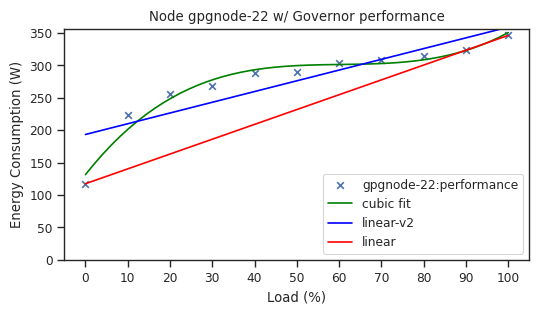

Node gpgnode-22 w/ Governor powersave -- Model Accuracy
Memory Power Draw: 0.016041666666666666W/GB
Idle: 94.77333333333333 | 100%: 347.1433333333334
RMSE of Linear Model: 63.10049556105327
RMSE of Linear v2 Model: 32.34080061510659
RMSE of Model: 10.598511556950378


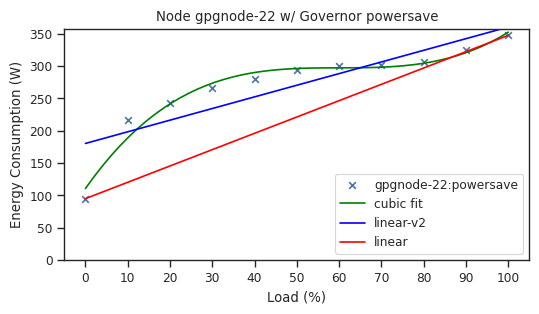

In [37]:
# Graph the Power Consumption for gpgnode-22
governors = ['performance', 'powersave']
plot_ts_report('gpgnode-22', governors, 128)

In [38]:
# GPG Node 22
print('GPG Node 22')
gpgnode_22 = generate_node_stats_all_models('gpgnode-22', 'ampliseq', 'south-scotland-300125-110225', 'gpg_22', ['performance', 'powersave'], True)
print(tabulate(gpgnode_22, headers, tablefmt='orgtbl'))
print('')
error_rows = report_error('gpg_22', 'performance|powersave', gpgnode_22)
print(tabulate(error_rows, err_headers, tablefmt='orgtbl'))

GPG Node 22
| setting                   |   core_energy (kWh) |   ram energy (kWh) |   total energy (kWh) |   emissions (gCO2e) |
|---------------------------+---------------------+--------------------+----------------------+---------------------|
| perf_performance          |          0.163902   |        0.00114189  |           0.165044   |                     |
| perf_powersave            |          0.162143   |        0.00115973  |           0.163303   |                     |
| gpg_22_performance        |          0.130595   |        0.000207781 |           0.130802   |            5.37482  |
| gpg_22_performance_linear |          0.158404   |        0.000207781 |           0.158612   |            6.5182   |
| performance_linear        |          0.100908   |        0.000207781 |           0.101116   |            4.15517  |
| performance_baseline      |          0.00301688 |        0.000207781 |           0.00322466 |            0.132056 |
| gpg_22_powersave          |          0.030

In [39]:
# Local Server
# todo (x2)

In [40]:
filename = 'data/models.txt'

with open(filename, 'w') as f:
    for model in MODELS:
        parts = model.split('=')
        func = parts[1].replace('x', 'cpu_usage')[:-2]
        f.write(parts[0] + "\n")
        f.write(func + "\n")

print(f'Models: stored in file {filename}')

Models: stored in file data/models.txt


In [41]:
# Show Results of Footprint Estimation using Average and Marginal CI Data for all Nodes
nodes = ['gpgnode-13', 'gpgnode-14', 'gpgnode-15', 'gpgnode-16', 'gpgnode-22']
node_prefixes = ['gpg_13', 'gpg_14', 'gpg_15', 'gpg_16', 'gpg_22']
ondemand = ['ondemand']
perf_power = ['performance', 'powersave']
govs_by_nodes = [ondemand, perf_power, perf_power, ondemand, perf_power]
results_records = []
results_header = ['Node', 'Governor', 'Energy (kWh)', 'Average Emissions (gCO2e)', 'Marginal Emissions (gCO2e)']
avg_ci = 'south-scotland-300125-110225'
marg_ci = 'uk-marg-010125-110225'

for node, prefix, govs in zip(nodes, node_prefixes, govs_by_nodes):
    for gov in govs:
        (info_1, data_1, bonus_1) = parse_summary(f'data/{node}/{gov}/results/ampliseq-1-{avg_ci}-{prefix}_{gov}_linear-summary.txt')
        (info_2, data_2, bonus_2) = parse_summary(f'data/{node}/{gov}/results/ampliseq-2-{avg_ci}-{prefix}_{gov}_linear-summary.txt')
        (info_3, data_3, bonus_3) = parse_summary(f'data/{node}/{gov}/results/ampliseq-3-{avg_ci}-{prefix}_{gov}_linear-summary.txt')

        model_avg = get_average(data_1, data_2, data_3)
        energy_avg = model_avg[ENERGY_CONSUMPTION] + model_avg[MEMORY_CONSUMPTION]
        emissions_avg = model_avg[CARBON_EMISSIONS]

        (marg_info_1, marg_data_1, marg_bonus_1) = parse_summary(f'data/{node}/{gov}/results/ampliseq-1-{marg_ci}-{prefix}_{gov}_linear-summary.txt')
        (marg_info_2, marg_data_2, marg_bonus_2) = parse_summary(f'data/{node}/{gov}/results/ampliseq-2-{marg_ci}-{prefix}_{gov}_linear-summary.txt')
        (marg_info_3, marg_data_3, marg_bonus_3) = parse_summary(f'data/{node}/{gov}/results/ampliseq-3-{marg_ci}-{prefix}_{gov}_linear-summary.txt')

        model_marg = get_average(marg_data_1, marg_data_2, marg_data_3)
        marg_energy = model_marg[ENERGY_CONSUMPTION] + model_marg[MEMORY_CONSUMPTION]
        marg_emissions = model_marg[CARBON_EMISSIONS]

        results_records.append([node, gov, str(round(energy_avg, 3)).zfill(3), str(round(emissions_avg, 2)).zfill(2), str(round(marg_emissions,2)).zfill(2)])

print(tabulate(results_records, results_header, tablefmt='orgtbl'))

print('\nlatex table\n')
for record in results_records:
    print(" & ".join(record) + "  \\\\")

| Node       | Governor    |   Energy (kWh) |   Average Emissions (gCO2e) |   Marginal Emissions (gCO2e) |
|------------+-------------+----------------+-----------------------------+------------------------------|
| gpgnode-13 | ondemand    |          0.144 |                        2.93 |                       141.95 |
| gpgnode-14 | performance |          0.146 |                        2.96 |                       142.94 |
| gpgnode-14 | powersave   |          0.15  |                        1.78 |                       154.53 |
| gpgnode-15 | performance |          0.155 |                        1.79 |                       159.3  |
| gpgnode-15 | powersave   |          0.165 |                        4.05 |                       157.93 |
| gpgnode-16 | ondemand    |          0.131 |                        7.89 |                       138.75 |
| gpgnode-22 | performance |          0.159 |                        6.52 |                       149.92 |
| gpgnode-22 | powersave   |         